In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from cbsim.net import Net
from cbsim.request import Request
from cbsim.stochastic import Stochastic

from cbsim.experiment import sample_stats
from cbsim.experiment import chi_square_norm

<H1>Simulate demand

<H2>Load network and inlet flows

In [2]:
net = Net()
net.load_from_file(fnodes='nodes.txt', flinks='links.txt')

# traffic flow studies from May 2021
days = 5
fdata = {
    0: [[68, 70, 92, 84, 119], [70, 82, 80, 67, 77]],           # Sławkowska
    2: [[52, 38, 35, 40, 54], [45, 38, 48, 40, 40]],            # Szczepańska
    4: [[67, 64, 113, 129, 131], [149, 157, 142, 142, 171]],    # Św. Anny
    5: [[30, 27, 31, 31, 43], [66, 64, 60, 55, 93]],            # Franciszkańska
    6: [[22, 38, 36, 35, 52], [149, 134, 120, 184, 102]],       # Poselska
    10: [[153, 143, 172, 176, 214], [130, 122, 119, 152, 142]], # Sienna
    12: [[43, 45, 49, 57, 60], [57, 48, 57, 59, 69]]            # Szpitalna
}

flows = {}
for f in fdata:
    d = fdata[f]
    flows[f] = int(np.array([d[0][i] + d[1][i] for i in range(days)]).mean())
_total = sum(flows.values()) # total number of requests to generate

loadpoints = {15: 'A', 28: 'B', 24: 'C', 19: 'D', 8: 'E', 20: 'F'}
probs = { 'R': 0.2, 'H': 0.05, 'S': 0.2, 'P': 0.15, 'W': 0.05 }

clients = [nd for nd in net.nodes if nd.type != 'N' and nd.type != 'L']
entries = sorted(flows.keys())
zones = sorted([r.code for r in net.regions])

print(flows, _total)

{0: 161, 2: 86, 4: 253, 5: 100, 6: 174, 10: 304, 12: 108} 1186


In [4]:
_total / len(zones)**2

18.53125

In [3]:
def sim_diff():
    # 1) generate requests
    generated = 0
    reqs = []
    while generated < _total:
        dst = np.random.choice(clients)
        if np.random.random() < probs[dst.type]:
            req = Request(0, None, dst)
            generated += 1
            reqs.append(req)

    # 2) generate demand using traditionial aproach
    net.demand = net.gen_demand(flows=flows, 
                                probs=probs,
                                requests=reqs,
                                s_weight=Stochastic(),
                                traditional=True)
    # calculate ODM
    odm1 = np.matrix([[0 for zone in zones] for entry in entries])
    for r in net.demand:
        i = entries.index(r.origin.nid)
        j = r.destination.region.code
        odm1[i, j] += 1
    print(odm1)
    print([odm1[i,:].sum() for i in range(odm1.shape[0])], odm1.sum(), 'prod')
    print([odm1[:,i].sum() for i in range(odm1.shape[1])], odm1.sum(), 'attr')

    # 3) generate demand using the proposed aproach
    net.demand = net.gen_demand(flows=flows, 
                                probs=probs,
                                requests=reqs,
                                s_weight=Stochastic(),
                                traditional=False)
    # calculate ODM
    odm2 = np.matrix([[0 for zone in zones] for entry in entries])
    for r in net.demand:
        i = entries.index(r.origin.nid)
        j = r.destination.region.code
        odm2[i, j] += 1
    print(odm2)
    print([odm2[i,:].sum() for i in range(odm2.shape[0])], odm2.sum(), 'prod')
    print([odm2[:,i].sum() for i in range(odm2.shape[1])], odm2.sum(), 'attr')

    # 4) calculate difference matrix
    odm = np.abs(odm1 - odm2)
    
    return odm1.mean(), odm1.std(), odm2.mean(), odm2.std(), odm.mean(), odm.std()

In [4]:
rfile = open('demand_sim_mean.txt', 'w')

for i in range(5):
    res = sim_diff()
    print(i + 1, res)
    rfile.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(res[0], res[1], res[2], res[3], res[4], res[5]))

rfile.close()

[[ 40  60   7   4   5   4  17  19]
 [  9  14   3   3   5  16  35  20]
 [ 13  28   9  12  22  62  33  52]
 [  2   8   4  17  26   4   4  17]
 [  3  12   6  41  31   5   5  22]
 [ 11  80 115  60  26   5  10  58]
 [ 12  77   7   3   2   1   5  10]]
[156, 105, 231, 82, 125, 365, 117] 1181 prod
[90, 279, 151, 140, 117, 97, 109, 198] 1181 attr
[[ 35  44  11   7   9  10  20  25]
 [  6  11   5   3   3  20  23  15]
 [  4  35  18  29  32  43  22  70]
 [  2   5  16  27  31   3   1  15]
 [  2  40  20  64  11   6   8  23]
 [ 18 106  81   9  24   7  15  44]
 [ 24  40   0   3   7   8  20   6]]
[161, 86, 253, 100, 174, 304, 108] 1186 prod
[91, 281, 151, 142, 117, 97, 109, 198] 1186 attr
1 (21.089285714285715, 23.54955018202068, 21.178571428571427, 20.795867672326104, 9.517857142857142, 10.131265383223663)
[[ 51  56   6   4   5   5  13  17]
 [ 12  13   3   3   6  20  28  18]
 [ 16  26   8  13  26  78  26  47]
 [  3   8   4  18  30   5   3  15]
 [  4  12   6  42  36   6   4  19]
 [ 14  74 107  61  31   

In [4]:
rfile = open('demand_sim_mean.txt', 'w')

for i in range(300):
    res = sim_diff()
    print(i + 1, res)
    rfile.write('{}\t{}\t{}\t{}\t{}\t{}\n'.format(res[0], res[1], res[2], res[3], res[4], res[5]))

rfile.close()

1 (21.125, 23.146322216344807, 21.178571428571427, 18.939855127347144, 9.910714285714286, 10.605384053317794)
2 (21.142857142857142, 23.80683318130425, 21.178571428571427, 20.831901311327726, 8.964285714285714, 10.307702192525545)
3 (21.178571428571427, 24.00231175090756, 21.178571428571427, 20.67789290769349, 8.5, 9.837973078114937)
4 (21.142857142857142, 23.06932763543447, 21.178571428571427, 19.459763563804767, 8.214285714285714, 8.585108131680874)
5 (21.178571428571427, 24.292934850969928, 21.178571428571427, 21.417705578443687, 9.964285714285714, 11.21855014460152)
6 (21.125, 23.1571205494737, 21.178571428571427, 20.75030734958017, 8.946428571428571, 10.266832246986171)
7 (21.125, 22.73218493992289, 21.178571428571427, 20.009022199691696, 9.517857142857142, 10.426599006230877)
8 (21.107142857142858, 22.678402699034866, 21.178571428571427, 18.591575610299127, 9.107142857142858, 8.764128535090745)
9 (21.125, 22.982961468382243, 21.178571428571427, 20.38829070714815, 9.30357142857142

<H2>Show results

In [2]:
def read_data(fname):
    res = []
    fdata = open(fname, 'r')
    for line in fdata.readlines():
        records = line.split()
        row = []
        for record in records:
            row.append(float(record))
        res.append(row)
    fdata.close()
    return res

In [3]:
mins = np.array(read_data('demand_sim_min.txt'))
maxs = np.array(read_data('demand_sim_max.txt'))
means = np.array(read_data('demand_sim_mean.txt'))
mins[:, 4].mean(), means[:, 4].mean(), maxs[:, 4].mean()
mins[:, 4].std(), means[:, 4].std(), maxs[:, 4].std()


(0.5239665078614704, 0.5028390874001943, 0.5900944906847614)

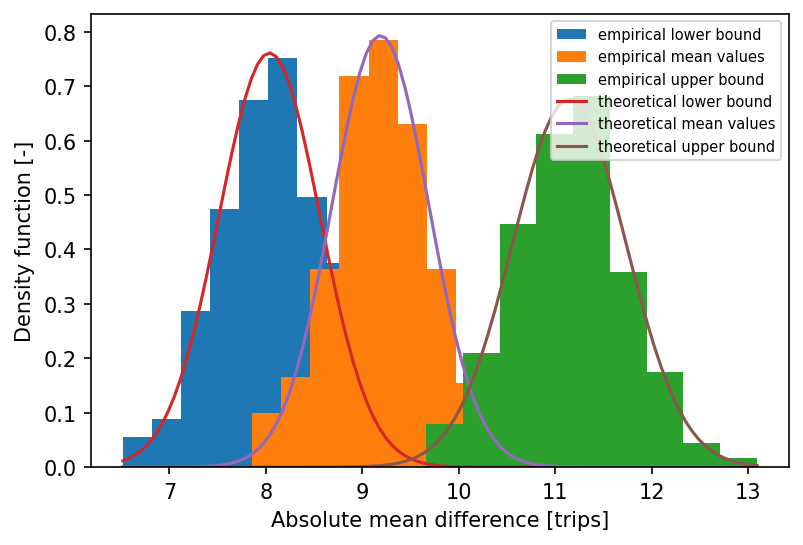

In [4]:
plt.figure(dpi=150)
xs = np.linspace(min(list(mins[:, 4]) + list(means[:, 4]) + list(maxs[:, 4])),
                 max(list(mins[:, 4]) + list(means[:, 4]) + list(maxs[:, 4])), 100)
plt.hist(mins[:, 4], density=True, label='empirical lower bound', bins=9)
plt.hist(means[:, 4], density=True, label='empirical mean values', bins=9)
plt.hist(maxs[:, 4], density=True, label='empirical upper bound', bins=9)
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(mins[:, 4])), label='theoretical lower bound')
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(means[:, 4])), label='theoretical mean values')
plt.plot(xs, stats.norm.pdf(xs, *stats.norm.fit(maxs[:, 4])), label='theoretical upper bound')
plt.legend(fontsize=7, loc='upper right')
plt.xlabel('Absolute mean difference [trips]', fontsize=10)
plt.ylabel('Density function [-]', fontsize=10)
plt.show()

In [10]:
sample_stats(mins[:, 4])

{'min': 6.518,
 'max': 9.232,
 'mean': 8.037,
 'std': 0.524,
 'kv': 0.0652,
 'var': 0.275,
 'u_alpha': 1.645,
 'error': 0.402,
 'size': 5.0}

In [11]:
sample_stats(means[:, 4])

{'min': 7.857,
 'max': 10.571,
 'mean': 9.187,
 'std': 0.503,
 'kv': 0.0547,
 'var': 0.253,
 'u_alpha': 1.645,
 'error': 0.459,
 'size': 3.0}

In [12]:
sample_stats(maxs[:, 4])

{'min': 9.661,
 'max': 13.089,
 'mean': 11.145,
 'std': 0.59,
 'kv': 0.0529,
 'var': 0.348,
 'u_alpha': 1.645,
 'error': 0.557,
 'size': 3.0}

{'chi2': 6.4503, 'test': 12.5916, 'df': 6}

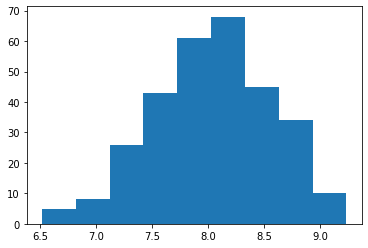

In [13]:
chi_square_norm(mins[:, 4])

{'chi2': 4.4634, 'test': 12.5916, 'df': 6}

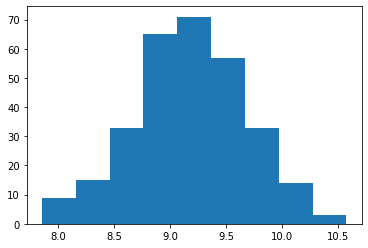

In [14]:
chi_square_norm(means[:, 4])

{'chi2': 2.5858, 'test': 12.5916, 'df': 6}

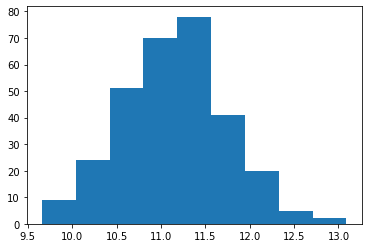

In [15]:
chi_square_norm(maxs[:, 4])